# Variance Reduction - Weight Windows

## Iteratively creating and utilizing a weight window to accelerate deep shielding simulations

This example simulates a sphere of material with a neutron source in the center.This example implements the MAGIC method of weight window generation on each simulation run.

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield and improving the weight window with each iteration.

Weight Windows are found using the MAGIC method and used to accelerate the simulation.

The variance reduction method used for this simulation is well documented in the OpenMC documentation
https://docs.openmc.org/en/stable/methods/neutron_physics.html

The MAGIC method is well described in the original publication
https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf


First we import ```openmc``` including ```openmc.lib``` and other packages needed for the example. We also configure the nuclear data path.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm  # used for plotting log scale graphs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import openmc
import openmc.lib  # this example makes use of openmc lib to run the simulations

# Setting the cross section path to the correct location in the docker image.
# If you are running this outside the docker image you will have to change this path to your local cross section path.
openmc.config['cross_sections'] = '/home/rworrall/nuclear_data/endfb-viii.0-hdf5/cross_sections.xml'

We create a couple of materials for the simulation

In [2]:
mat_water = openmc.Material()
mat_water.add_element("H", 1)
mat_water.add_element("O", 2)
mat_water.set_density("g/cm3", 1.0)

my_materials = openmc.Materials([mat_water])

Now we define and plot the spherical geometry.

In [3]:
# outer surface at 500 cm
outer_surface = openmc.model.RectangularParallelepiped(-300, 300, -300, 300, -300, 300, boundary_type="vacuum")

# A single region below the surface
region_1 = -outer_surface

# A single cell full of water
cell_1 = openmc.Cell(region=region_1)
cell_1.fill = mat_water

my_geometry = openmc.Geometry([cell_1])

Now we plot the geometry and color by materials.

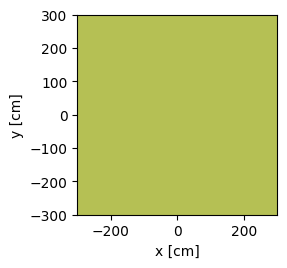

In [4]:
plot = my_geometry.plot(basis='xy', color_by='material') 
plot.figure.savefig('geometry_top_down_view.png', bbox_inches="tight")

Next we create a point source, this also uses the same geometry parameters to place in the center of the room regardless of the values of the parameters.

In [5]:
# location of the point source
space = openmc.stats.Point((0, 0, 0))
angle = openmc.stats.Isotropic()

# all (100%) of source particles are 14MeV energy
energy = openmc.stats.Discrete([14e6], [1.0])

source = openmc.IndependentSource(space=space, angle=angle, energy=energy)
source.particle = "neutron"

Next we create a mesh that encompasses the entire geometry and scores neutron flux

In [6]:
mesh = openmc.RegularMesh().from_domain(domain=my_geometry, dimension=[20,20,20])

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter]
flux_tally.scores = ["flux"]
flux_tally.id = 55  # we set the ID number here as we need to access it during the openmc lib run

# adds the mesh tally to the model
my_tallies = openmc.Tallies()
my_tallies.append(flux_tally)

tallies = openmc.Tallies([flux_tally])

Creates the simulation settings

In [7]:
my_settings = openmc.Settings()
my_settings.run_mode = "fixed source"
my_settings.source = source
my_settings.particles = 250
my_settings.batches = 10
my_settings.max_history_splits = 4000  # controls the total number of maximum splits a particle can do over the entire lifetime

# no need to write the tallies.out file which saves space and time when large meshes are used
my_settings.output = {'tallies': False}

Creates and exports the model

In [8]:
model = openmc.Model(my_geometry, my_materials, my_settings, my_tallies)

# deletes old input and output files
!rm *.xml || true
!rm *.h5 || true

model.export_to_xml()  # this is necessary as openmc.lib loads up the model.xml file

rm: cannot remove '*.xml': No such file or directory
rm: cannot remove '*.h5': No such file or directory


Now we want to plot the results of the simulation. We want to do this twice to compare the results so I've written this up as a function that we can call.

In [9]:
def plot_mesh_tally_and_weight_window(statepoint_filename, weight_window_filename, image_filename):
    # load flux tally from statepoint file
    with openmc.StatePoint(statepoint_filename) as sp:
        flux_tally = sp.get_tally(name="flux tally")

    tally_mesh = flux_tally.find_filter(openmc.MeshFilter).mesh
    tally_mesh_extent = tally_mesh.bounding_box.extent['xy']

    # get slice of flux mean and std dev values on the xy basis mid z axis.
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True).squeeze()[:,:,int(mesh.dimension[2]/2)]
    flux_std_dev = flux_tally.get_reshaped_data(value='std_dev', expand_dims=True).squeeze()[:,:,int(mesh.dimension[1]/2)]
    
    # calculate values for a slice showing relative uncertainties
    flux_rel_err = np.divide(flux_std_dev, flux_mean, out=np.zeros_like(flux_std_dev), where=flux_mean!=0)
    flux_rel_err[flux_rel_err == 0.0] = np.nan
    
    # get slice of ww lower bounds
    wws=openmc.hdf5_to_wws(weight_window_filename)
    ww = wws[0]  # get the one and only mesh tally
    ww_mesh = ww.mesh  # get the mesh that the weight window is mapped on
    ww_mesh_extent = ww_mesh.bounding_box.extent['xy']
    reshaped_ww_vals = ww.lower_ww_bounds.reshape(mesh.dimension)
    print('reshaped_ww_vals.shape', reshaped_ww_vals.shape)
    # slice on XZ basis, midplane Y axis
    slice_of_ww = reshaped_ww_vals[:,:,int(mesh.dimension[1]/2)]
    
    # set up 3 subplots for the flux, std dev and ww slices
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # function will set colour bar on a sub plot
    def add_colourbar(ax, im):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        return fig.colorbar(im, cax=cax)

    # add slice of flux to subplots
    im_flux = axes[0].imshow(
        flux_mean.T,
        # origin="lower",
        extent=tally_mesh_extent,
        norm=LogNorm(vmin=1e-10, vmax=1)
    )
    axes[0].set_title("Flux Mean")
    add_colourbar(axes[0], im_flux)

    # add slice of flux std dev to subplots
    im_std_dev = axes[1].imshow(
        flux_rel_err,
        # origin="lower",
        extent=tally_mesh_extent,
        vmin=0.0,
        vmax=1.0,
        cmap='RdYlGn_r'
    )
    axes[1].set_title("Flux Mean rel. error")
    add_colourbar(axes[1], im_std_dev)

    # add slice of ww to subplots
    im_ww_lower = axes[2].imshow(
        slice_of_ww.T,
        # origin="lower",
        extent=ww_mesh_extent,
        norm=LogNorm(vmin=1e-14, vmax=1e-1),
    )
    axes[2].set_title("WW lower bound")
    add_colourbar(axes[2], im_ww_lower)
    
    plt.tight_layout()
    plt.savefig(image_filename)
    plt.close()

Now we make use of openmc.lib to control the simulation. Documentation on openmc.lib is here
https://docs.openmc.org/en/stable/pythonapi/capi.html

We run 5 iterations with each iteration improving the weight window.

In [10]:
with openmc.lib.run_in_memory():

    # loads up a live pointer to the tally with id=55, at this stage the tally is empty
    tally = openmc.lib.tallies[55]

    # makes weight windows from the tally, at this stage the values are empty
    wws = openmc.lib.WeightWindows.from_tally(tally, particle='neutron')

    # You could customise the weight windows by changing this attributes from their defaults
    # wws.survival_ratio
    # wws.max_lower_bound_ratio
    # wws.weight_cutoff
    # wws.max_split  # controls the total number of maximum splits a particle can do per mesh voxel

    # 5 iterations of weight window improvements
    for i in range(5):

        # run the simulation
        openmc.lib.run()

        # improves the weight window with the latest tally results
        wws.update_magic(tally)

        # we write out the weight window map for plotting later
        openmc.lib.export_weight_windows(filename=f'weight_windows{i}.h5')
        # we write out the statepoint so that the tally can be plotted later
        openmc.lib.statepoint_write(filename=f'statepoint_simulation_{i}.h5')

        # turns on the weight windows to ensure they are used
        openmc.lib.settings.weight_windows_on = True

        # creates a plot of the flux, std_dev and weight window
        plot_mesh_tally_and_weight_window(
            f'statepoint_simulation_{i}.h5',
            f'weight_windows{i}.h5',
            f'plot_{i}.png'
        )

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

HDF5-DIAG: Error detected in HDF5 (1.10.10) thread 1:
  #000: ../../../src/H5Dio.c line 316 in H5Dwrite(): can't write data
    major: Dataset
    minor: Write failed
  #001: ../../../src/H5Dio.c line 713 in H5D__write(): no output buffer
    major: Invalid arguments to routine
    minor: Bad value
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)


 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 5.1767e-02 seconds
   Reading cross sections          = 4.8671e-02 seconds
 Total time in simulation          = 2.0402e+00 seconds
   Time in transport only          = 2.0332e+00 seconds
   Time in active batches          = 2.0402e+00 seconds
   Time accumulating tallies       = 2.8500e-03 seconds
   Time writing statepoints        = 4.6598e-03 seconds
 Total time for finalization       = 6.3700e-07 seconds
 Total time elapsed                = 2.0925e+00 seconds
 Calculation Rate (active)         = 1225

HDF5-DIAG: Error detected in HDF5 (1.10.10) thread 1:
  #000: ../../../src/H5Dio.c line 316 in H5Dwrite(): can't write data
    major: Dataset
    minor: Write failed
  #001: ../../../src/H5Dio.c line 713 in H5D__write(): no output buffer
    major: Invalid arguments to routine
    minor: Bad value
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 5.1767e-02 seconds
   Reading cross sections          = 4.8671e-02 seconds
 Total time in simulation          = 7.3966e+00 seconds
   Time in transport only          = 7.3804e+00 seconds
   Time in active batches          = 7.3966e+00 seconds
   Time accumulating tallies       = 9.1440e-03 seconds
   Time writing statepoints        = 8.4722e-03 seconds
 Total time for finalization       = 1.4830e-06 seconds
 Total time elapsed                = 7.4493e+00 seconds
 Calculation Rate (active)         = 337.

HDF5-DIAG: Error detected in HDF5 (1.10.10) thread 1:
  #000: ../../../src/H5Dio.c line 316 in H5Dwrite(): can't write data
    major: Dataset
    minor: Write failed
  #001: ../../../src/H5Dio.c line 713 in H5D__write(): no output buffer
    major: Invalid arguments to routine
    minor: Bad value
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 5.1767e-02 seconds
   Reading cross sections          = 4.8671e-02 seconds
 Total time in simulation          = 1.4223e+01 seconds
   Time in transport only          = 1.4195e+01 seconds
   Time in active batches          = 1.4223e+01 seconds
   Time accumulating tallies       = 1.4933e-02 seconds
   Time writing statepoints        = 1.2172e-02 seconds
 Total time for finalization       = 2.4860e-06 seconds
 Total time elapsed                = 1.4277e+01 seconds
 Calculation Rate (active)         = 175.

HDF5-DIAG: Error detected in HDF5 (1.10.10) thread 1:
  #000: ../../../src/H5Dio.c line 316 in H5Dwrite(): can't write data
    major: Dataset
    minor: Write failed
  #001: ../../../src/H5Dio.c line 713 in H5D__write(): no output buffer
    major: Invalid arguments to routine
    minor: Bad value
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Creating state point statepoint.10.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 5.1767e-02 seconds
   Reading cross sections          = 4.8671e-02 seconds
 Total time in simulation          = 2.0286e+01 seconds
   Time in transport only          = 2.0239e+01 seconds
   Time in active batches          = 2.0286e+01 seconds
   Time accumulating tallies       = 2.9955e-02 seconds
   Time writing statepoints        = 1.7142e-02 seconds
 Total time for finalization       = 2.9910e-06 seconds
 Total time elapsed                = 2.0340e+01 seconds
 Calculation Rate (active)         = 123.

HDF5-DIAG: Error detected in HDF5 (1.10.10) thread 1:
  #000: ../../../src/H5Dio.c line 316 in H5Dwrite(): can't write data
    major: Dataset
    minor: Write failed
  #001: ../../../src/H5Dio.c line 713 in H5D__write(): no output buffer
    major: Invalid arguments to routine
    minor: Bad value
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/rworrall/code/python/venv/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


The iterative improvement of the flux / standard deviation / weight windows with each simulation run can be seen when we plot all the simulation results one after each other.

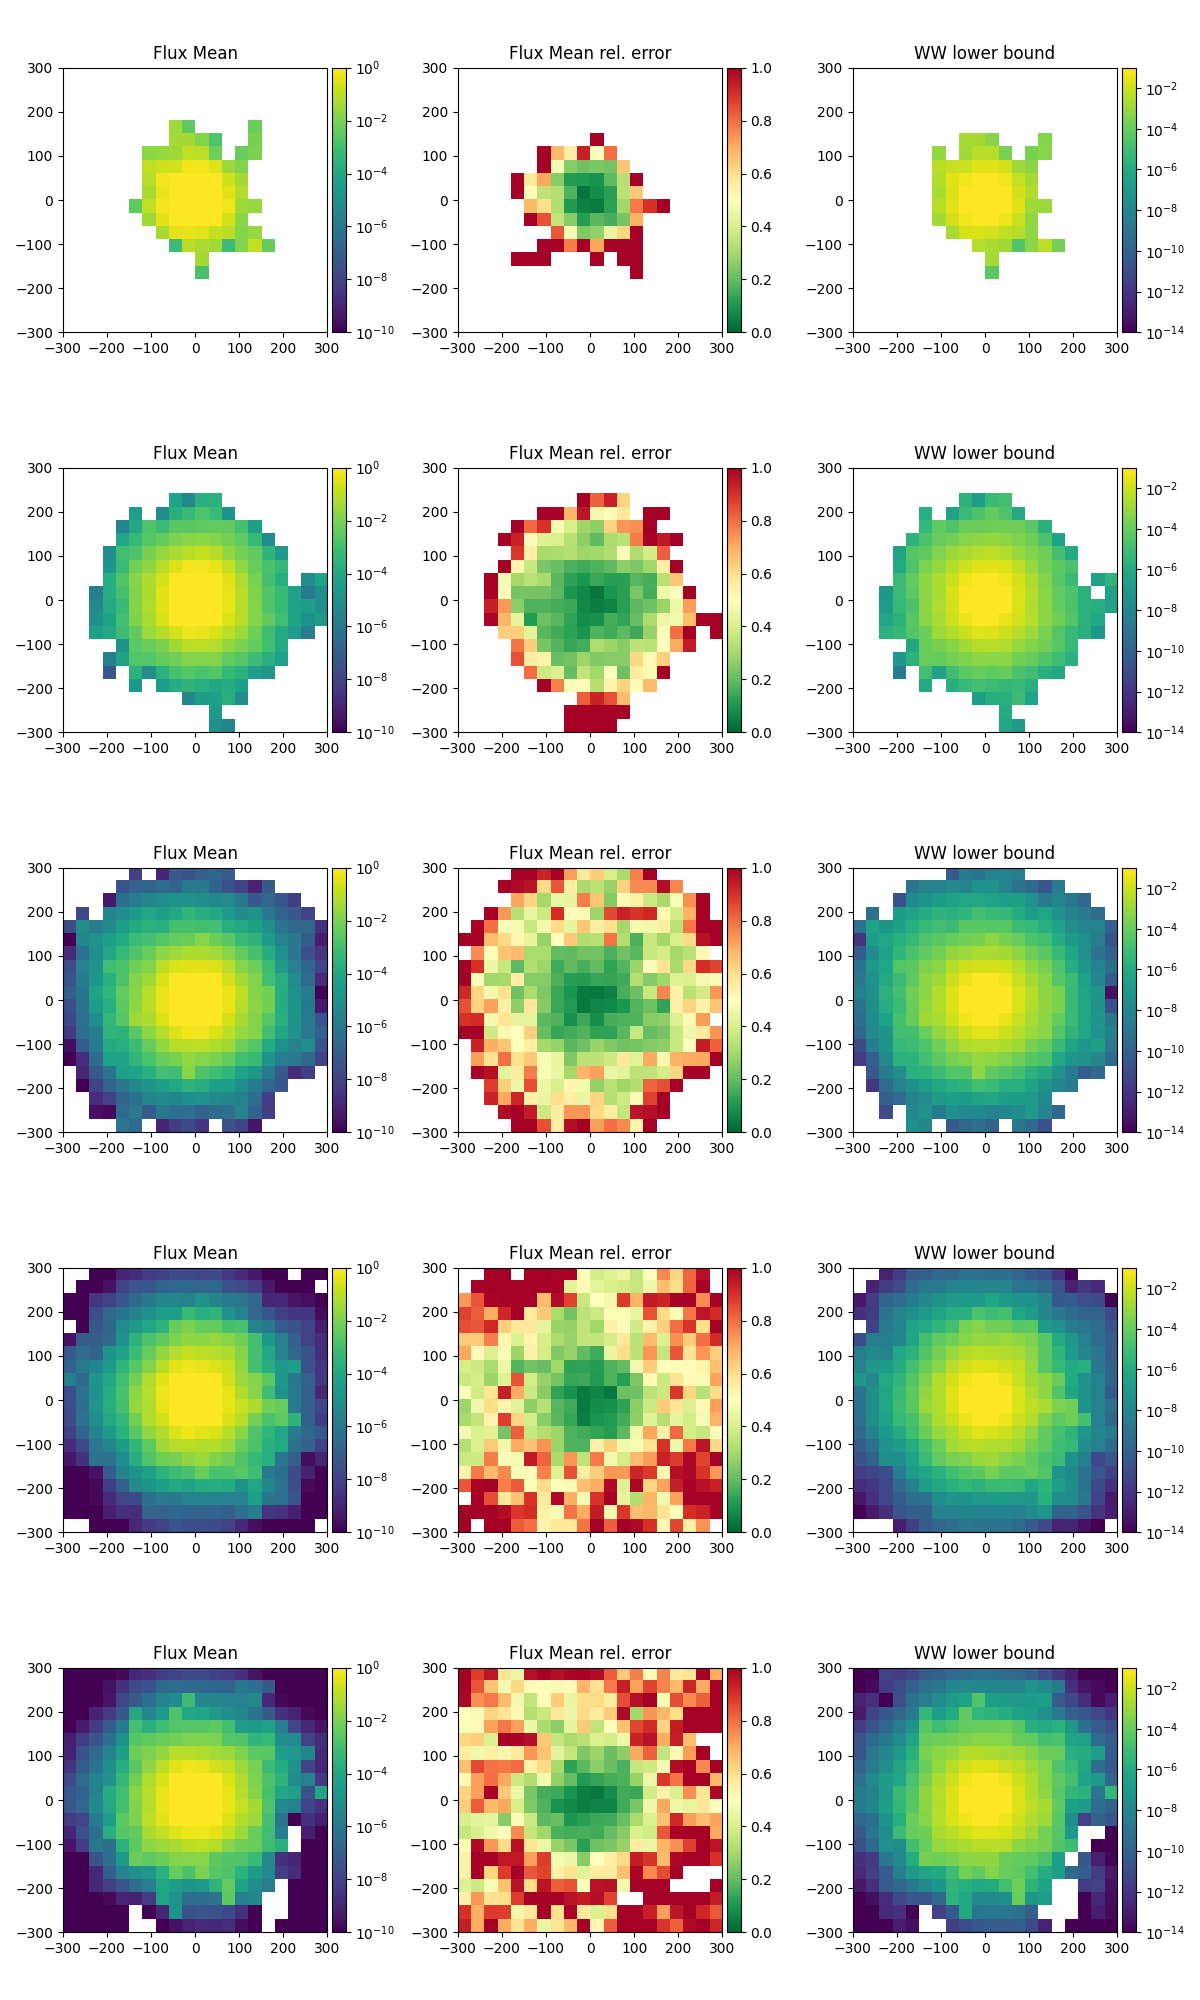

In [11]:
from PIL import Image
images = [Image.open(x) for x in [f'plot_{c}.png' for c in range(5)]]
widths, heights = zip(*(i.size for i in images))

total_height = sum(heights)
max_width = max(widths)

new_im = Image.new('RGB', (max_width, total_height))
y_offset = 0
for im in images:
  new_im.paste(im, (0,y_offset))
  y_offset += im.size[1]
new_im.save('flux_std-dev_ww_for_all_simulations_reset.png')
new_im

Learning outcome

Weight windows can be incrementally improved by running subsequent simulations.

Running lots of small simulations where the weight window can incrementally improve the weight window can yield better results than a big single simulation to generate weight windows and a single big simulation to make use of the weight windows.

Doing this iteration with openmc.lib means we don't need to reload the nuclear data between simulations which saves time.

Additionally we have access to openmc.lib methods which are necessary for updating the weight window with the MAGIC method and exporting the weight window to a h5 file.
